# Parallax Determination
## AS5014 - Physics of Galaxy
### Bakuh Danang Setyo Budi - 10319008

In [1]:
from astroquery.gaia import Gaia
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import numpy as np
import math as m
import scipy.integrate as integrate
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import rv_continuous
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "cmr10"
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['mathtext.fontset'] = "cm"

# 1. Query Gaia Data

In [2]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [3]:
for column in meta.columns:
    print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

## Pick 10 random data

In [4]:
def QueryGaiadr3 () :
    query1 = """SELECT 
    TOP 5000
    designation,source_id, ra,ra_error, dec,dec_error, parallax,parallax_error,parallax_over_error
    FROM gaiadr3.gaia_source
    WHERE parallax IS NOT NULL AND random_index between 0 and 200000000000
    AND parallax_over_error between -50 and 50
    AND parallax between -0.5 and 10
    """
    job = Gaia.launch_job(query1)
    results = job.get_results()
    
    plt.hist(1/results['parallax_over_error'],bins=5000)
    plt.xlim(-10,0.1)
    
    select = results[((1/results["parallax_over_error"])<0.1) & (results["parallax"]>0) ]
    rows_numbers_to_keep = np.random.choice(len(select), 3, replace=False)
    sub = select[rows_numbers_to_keep]
    
    select1 = results[(results["parallax_over_error"]>2) & ((1/results["parallax_over_error"])>0.1) & (results["parallax"]>0) ]
    rows_numbers_to_keep = np.random.choice(len(select1), 2, replace=False)
    sub1 = select1[rows_numbers_to_keep]
    
    select2 = results[(results["parallax"]<0)]
    rows_numbers_to_keep = np.random.choice(len(select2), 1, replace=False)
    sub2 = select2[rows_numbers_to_keep]
    
    select3 = results[((1/results["parallax_over_error"])>0.2) & ((1/results["parallax_over_error"])<0.45)& (results["parallax"]>0) ]
    rows_numbers_to_keep = np.random.choice(len(select3), 4, replace=False)
    sub3 = select3[rows_numbers_to_keep]
    
    data = vstack([sub,sub1,sub3,sub2])
    data['f'] = 1/data['parallax_over_error']
    
    return data

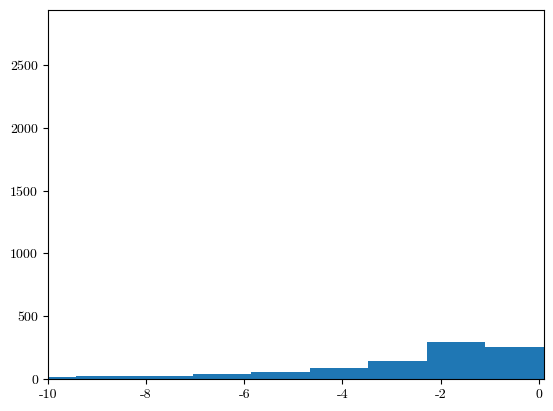

In [5]:
data = QueryGaiadr3()

DESIGNATION,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,f
,,deg,mas,deg,mas,mas,mas,,
object,int64,float64,float32,float64,float32,float64,float32,float32,float32
Gaia DR3 5937201406676503296,5937201406676503296,250.59615225981503,0.04272711,-51.23671943507677,0.031875357,0.6985506276674991,0.058436442,11.954024,0.08365384
Gaia DR3 5937144438244247808,5937144438244247808,251.44964890217733,0.0347268,-50.7441078848362,0.024143094,2.23235241028271,0.048602156,45.93114,0.021771722
Gaia DR3 5937144536934831872,5937144536934831872,251.50064176929934,0.016325103,-50.756720973316156,0.011981835,0.44706497406835743,0.023889467,18.713894,0.053436235
Gaia DR3 5937173266047608448,5937173266047608448,250.24010196894105,0.42492065,-51.61290953385978,0.2862781,1.8722471635988698,0.4987841,3.7536225,0.2664093
Gaia DR3 5937201337956989056,5937201337956989056,250.6263197254169,0.16060397,-51.26242766996672,0.2004288,0.26372389770370297,0.12780152,2.0635428,0.48460346
Gaia DR3 5937081662906234880,5937081662906234880,251.5712468494443,0.18738858,-51.5984364843916,0.13478875,0.7710247081480704,0.23506925,3.2799897,0.304879
Gaia DR3 5937173334780460160,5937173334780460160,250.21100536791508,1.010812,-51.590659051763545,0.6111859,2.9282973162649246,0.82128626,3.5655015,0.28046545
Gaia DR3 5937201402302711040,5937201402302711040,250.59922392142363,0.093839474,-51.24531302093099,0.06686687,0.5267423506163634,0.12937328,4.0714927,0.24561016


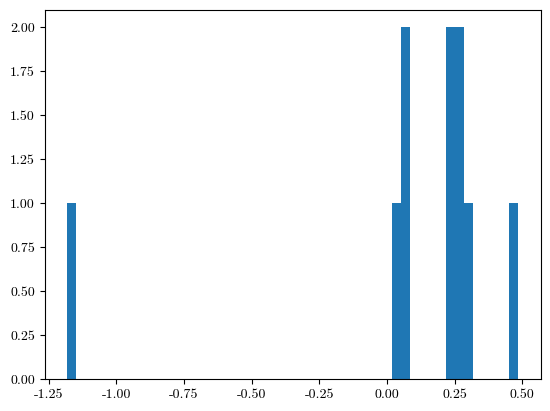

In [6]:
plt.hist(data['f'],bins=50)
data

# 2. Estimating Distance from Parallax

## Bayesian Theorem

## $$
P(r|\varpi,\sigma_\varpi) = \frac{1}{Z} P(\varpi|r,\sigma_\varpi) P(r) \\
Z = \int_{r=0}^{r=\infty}P(\varpi|r,\sigma_\varpi) P(r) \\
$$
## Likelihood
# $$
P(\varpi|r,\sigma_\varpi) = \frac{1}{\sqrt{2\pi}\sigma_\varpi}\exp{\left[ -\frac{1}{2\sigma_\varpi^2}\left( \varpi -\frac{1}{r}\right)^2 \right]}
$$

## Prior
### Uniform Density
### $$
P(r) = \frac{1}{r_{limit}} , \text{for }0<r\le r_{limit} \\
P(r) = 0 , \text{for elsewhere}
$$
### Constant Density
### $$
P(r) = \frac{3r^2}{r_{limit}^3} , \text{for }0<r\le r_{limit} \\
P(r) = 0 , \text{for elsewhere}
$$
### Exponential Density
### $$
P(r) = \frac{r^2}{2L^3} \exp{\left(-\frac{r}{L}\right)} , \text{for }0<r \\
P(r) = 0 , \text{for elsewhere}
$$

### Definition of some functions

In [7]:
def cons(r,rlim) :
    return 3*r**2/rlim**3

def eks(r,L) :
    return (r**2/(2*L**3))*np.exp(-r/L)

def like (rmax,i) :
    distance = np.linspace(0.1, rmax , 100000)      
    likelihoodd = norm.pdf(x=1/distance, scale=data['parallax_error'][i]/1000, loc=data['parallax'][i]/1000)
    normalization, _ = integrate.quad(lambda t: norm.pdf(x=1/t, scale=data['parallax_error'][i]/1000, loc=data['parallax'][i]/1000), a=0, b=rmax)
    likelihoodd /= normalization
    return distance,likelihoodd

In [8]:
def like_pdf (i) :
    if (data['f'][i] < 0.1) & (data['f'][i] > 0):
        batas = 2000/abs(data['parallax'][i])
        h = like(batas,i)
        dist1 = h[0]
        like1 = h[1]
    else :
        batas = 5000/abs(data['parallax'][i])
        h = like(batas,i)
        dist1 = h[0]
        like1 = h[1]

    return dist1,like1

def uniden_pdf (i) :
    l = like_pdf(i)
    distance = l[0]
    likelihod = l[1]
    rmax = 1e5
    prior = uniform.pdf(x=distance, scale=rmax)
    posterior = prior*l[1]
    posterior_norm = integrate.trapezoid(posterior, distance)
    posterior /= posterior_norm
    return distance,prior,likelihod, posterior, posterior/max(posterior)

def consden_pdf (i) :
    l = like_pdf(i)
    distance = l[0]
    likelihod = l[1]
    rmax = 1e5
    prior = cons(distance,rmax)
    posterior = prior*l[1]
    posterior_norm = integrate.trapezoid(posterior, distance)
    posterior /= posterior_norm
    return distance,prior,likelihod, posterior, posterior/max(posterior)

def expoden_pdf (i) :
    l = like_pdf(i)
    distance = l[0]
    likelihod = l[1]
    L = 1350
    rmax = max(distance)
    
    prior = eks(distance,L)
    posterior = prior*likelihod
    posterior_norm = integrate.trapezoid(posterior, distance)
    posterior /= posterior_norm
    return distance,prior,likelihod, posterior, posterior/max(posterior),L

In [9]:
def uncertain (x,y) :
    import pandas as pd
    lis = pd.DataFrame({"x" : x,"y" :y})
    
    mode = x[np.argmax(y)]
    y_new =  0.5*max(y)
   
    if mode != max(x) and mode != min(x) and y_new > y[np.argmax(x)] and (x[np.argmax(y)]/1000) < 99 :
        lis1 = lis[lis["x"]<mode]

        

        lis11 = lis1[lis1["y"]<y_new]

        id1 = lis11.idxmax()[0]


        x1l = lis['x'][id1]


        x1r = lis['x'][id1+1]

        y1l = lis['y'][id1]
        y1r = lis['y'][id1+1]

        halfmax_l = x1l + ((y_new-y1l)*(x1r-x1l)/(y1r-y1l))

        lis2 = lis[lis["x"]>mode]

        lis22 = lis2[lis2["y"]<y_new]

        id2 = lis22.idxmin()[0]

        x2l = lis['x'][id2]
        x2r = lis['x'][id2+1]

        y2l = lis['y'][id2]
        y2r = lis['y'][id2+1]

        halfmax_r = x2l + ((y_new-y2l)*(x2r-x2l)/(y2r-y2l))
        
    else :
        halfmax_l = 0
        halfmax_r = 0
        mode = 0

    return halfmax_l,halfmax_r,mode

def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return m.floor(n*multiplier + 0.5) / multiplier

### Definition Main Program

In [46]:
def parden (i,save) :
    fig, ax = plt.subplots(2, 3, figsize=(18,10))
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(str(data['DESIGNATION'][i]) + "\n" r" $\varpi \ =$ " + str(round_half_up(data['parallax'][i],4)) +" $\pm$ "+str(round_half_up(data['parallax_error'][i],4)) +" $\mu as$" "\n" "$f=$"+str(round_half_up(data['f'][i],3)), fontsize=25,y=1.03)
    
    
    U = uniden_pdf(i)
    ax[0][0].plot(U[0]/1000,U[2],label="Likelihood",alpha=0.5,color="black",linestyle="--")
    ax[0][0].plot(U[0]/1000,U[1],label="Prior",alpha=0.5,color="black",linestyle="dashdot")
    ax[0][0].plot(U[0]/1000,U[3],label="Posterior",color="black")
    ax[0][0].set_xlim(min(U[0]/1000),max(U[0]/1000))
    ax[0][0].set_xlabel('distance (kpc)',size=12)
    ax[0][0].set_ylabel('Probability',size=12)
    ax[0][0].grid()
    ax[0][0].set_title("Uniform Distance Prior $r_{lim} =100$ kpc",size=18)
    ax[0][0].legend()
    
    V = consden_pdf(i)
    ax[0][1].plot(V[0]/1000,V[2],label="Likelihood",alpha=0.5,color="black",linestyle="--")
    ax[0][1].plot(V[0]/1000,V[1],label="Prior",alpha=0.5,color="black",linestyle="dashdot")
    ax[0][1].plot(V[0]/1000,V[3],label="Posterior",color="black")
    ax[0][1].set_xlim(min(V[0]/1000),max(V[0]/1000))
    ax[0][1].set_xlabel('distance (kpc)',size=12)
    ax[0][1].set_ylabel('Probability',size=12)
    ax[0][1].grid()
    ax[0][1].set_title("Uniform Density Prior $r_{lim} =100$ kpc",size=18)
    ax[0][1].legend()
    
    W = expoden_pdf(i)
    
    ax[0][2].plot(W[0]/1000,W[2],label="Likelihood",alpha=0.5,color="black",linestyle="--")
    ax[0][2].plot(W[0]/1000,W[1],label="Prior",alpha=0.5,color="black",linestyle="dashdot")
    ax[0][2].plot(W[0]/1000,W[3],label="Posterior",color="black")
    if data['f'][i] >-1 :
        ax[0][2].set_xlim(min(W[0]/1000),max(W[0]/1000))
        ax[1][2].set_xlim(min(W[0]/1000),max(W[0]/1000))
    else :
        ax[0][2].set_xlim(min(W[0]/1000),20)
        ax[1][2].set_xlim(min(W[0]/1000),20)
                          
    ax[0][2].set_xlabel('distance (kpc)',size=12)
    ax[0][2].set_ylabel('Probability',size=12)
    ax[0][2].grid()
    ax[0][2].set_title("Exponential Density Prior $L =1.35$ kpc",size=18)
    ax[0][2].legend()
    
    sig1 = uncertain(U[0],U[3])
    if sig1[0] != 0 :
        ax[1][0].axvline(sig1[0]/1000,linestyle="--",alpha=0.5,label="FWHM")
        ax[1][0].axvline(sig1[1]/1000,linestyle="--",alpha=0.5)
        ax[1][0].axvline(sig1[2]/1000,linestyle="--",alpha=0.5,color="red",label="Mode")
        diss1 = sig1[2]/1000
        plus1 = (sig1[1]-sig1[2])/1000
        minn1 = (sig1[2]-sig1[0])/1000
        ax[1][0].set_title(r"d = ${:.4f}^{{+{:.4f}}}_{{-{:.4f}}}$ kpc".format(diss1,plus1,minn1),size=20,y=1.01)
    
    
    ax[1][0].plot(U[0]/1000,U[3],label="Posterior",color="black")
    ax[1][0].set_xlim(min(U[0]/1000),max(U[0]/1000))
    ax[1][0].set_xlabel('distance (kpc)',size=12)
    ax[1][0].set_ylabel('Probability',size=12)
    ax[1][0].grid()
    ax[1][0].legend()
    
    sig2 = uncertain(V[0],V[3])
    if sig2[0] != 0 :
        ax[1][1].axvline(sig2[0]/1000,linestyle="--",alpha=0.5,label="FWHM")
        ax[1][1].axvline(sig2[1]/1000,linestyle="--",alpha=0.5)
        ax[1][1].axvline(sig2[2]/1000,linestyle="--",alpha=0.5,color="red",label="Mode")
        diss2 = sig2[2]/1000
        plus2 = (sig2[1]-sig2[2])/1000
        minn2 = (sig2[2]-sig2[0])/1000
        ax[1][1].set_title(r"d = ${:.4f}^{{+{:.4f}}}_{{-{:.4f}}}$ kpc".format(diss2,plus2,minn2),size=20,y=1.01)
    
    ax[1][1].plot(V[0]/1000,V[3],label="Posterior",color="black")
    ax[1][1].set_xlim(min(V[0]/1000),max(V[0]/1000))
    ax[1][1].set_xlabel('distance (kpc)',size=12)
    ax[1][1].set_ylabel('Probability',size=12)
    ax[1][1].grid()
    
    ax[1][1].legend()
    
    sig3 = uncertain(W[0],W[3])
    if sig3[0] != 0 :
        ax[1][2].axvline(sig3[0]/1000,linestyle="--",alpha=0.5,label="FWHM")
        ax[1][2].axvline(sig3[1]/1000,linestyle="--",alpha=0.5)
        ax[1][2].axvline(sig3[2]/1000,linestyle="--",alpha=0.5,color="red",label="Mode")
        diss3 = sig3[2]/1000
        plus3 = (sig3[1]-sig3[2])/1000
        minn3 = (sig3[2]-sig3[0])/1000
        ax[1][2].set_title(r"d = ${:.4f}^{{+{:.4f}}}_{{-{:.4f}}}$ kpc".format(diss3,plus3,minn3),size=20,y=1.01)
    
    
    ax[1][2].plot(W[0]/1000,W[3],label="Posterior",color="black")
   
    ax[1][2].set_xlabel('distance (kpc)',size=12)
    ax[1][2].set_ylabel('Probability',size=12)
    ax[1][2].grid()
    ax[1][2].legend()
    
    if save == "yes" :
        fig.savefig(str(i+1)+" "+str(data['DESIGNATION'][i]),bbox_inches='tight')

### Save parameter output into csv

In [43]:
diss1 =[]
diss2 =[]
diss3 =[]

plus1 =[]
plus2 =[]
plus3 =[]

minn1 =[]
minn2 =[]
minn3 =[]

obj =[]
import pandas as pd
for i in range (len(data)) :
    U = uniden_pdf(i)
    V = consden_pdf(i)
    W = expoden_pdf(i)
    sig1 = uncertain(U[0],U[3])
    sig2 = uncertain(V[0],V[3])
    sig3 = uncertain(W[0],W[3])
    
    if sig1[0] != 0 :
        diss1.append(sig1[2]/1000)
        plus1.append((sig1[1]-sig1[2])/1000)
        minn1.append((sig1[2]-sig1[0])/1000)
    else : 
        diss1.append(0)
        plus1.append(0)
        minn1.append(0)
    if sig2[0] != 0 :
        diss2.append(sig2[2]/1000)
        plus2.append((sig2[1]-sig2[2])/1000)
        minn2.append((sig2[2]-sig2[0])/1000)
    else : 
        diss2.append(0)
        plus2.append(0)
        minn2.append(0) 
        
    if sig3[0] != 0 :
        diss3.append(sig3[2]/1000)
        plus3.append((sig3[1]-sig3[2])/1000)
        minn3.append((sig3[2]-sig3[0])/1000)
    else : 
        diss3.append(0)
        plus3.append(0)
        minn3.append(0) 
    
    obj.append(i+1)
datt = pd.DataFrame({"Objek" : obj,"distance_ud" : diss1 ,"distance_usd" : diss2,"distance_exp" : diss3,"sig+_ud" :plus1 ,"sig+_usd" :plus2 ,"sig+_exp" :plus3 ,"sig-_ud" :minn1 ,"sig-_usd" :minn2 ,"sig-_exp" :minn3 })

In [44]:
datt

,Objek,distance_ud,distance_usd,distance_exp,sig+_ud,sig+_usd,sig+_exp,sig-_ud,sig-_usd,sig-_exp
0,1,1.431543,1.452156,1.440990,0.156397,0.162592,0.158464,0.128364,0.132731,0.129944
1,2,0.447959,0.448380,0.448317,0.011784,0.011817,0.011804,0.011197,0.011218,0.011221
2,3,2.236794,2.249723,2.238986,0.150198,0.152482,0.150162,0.132385,0.134230,0.132429
3,4,0.534123,0.644522,0.610847,0.244103,0.534483,0.377079,0.127539,0.188624,0.166815
4,5,3.791773,0.000000,3.411828,5.038319,0.000000,1.943774,1.377473,0.000000,1.039777
5,6,1.297003,0.000000,1.435260,0.726257,0.000000,0.886903,0.342621,0.000000,0.409189
6,7,0.341493,0.424524,0.406016,0.168371,0.467687,0.318281,0.084773,0.132861,0.120163
7,8,1.898465,2.208389,1.965291,0.772354,1.361478,0.783676,0.425858,0.585898,0.446516
8,9,0.665097,0.744443,0.719469,0.229950,0.337967,0.288088,0.135930,0.173123,0.159474
9,10,0.000000,0.000000,3.700712,0.000000,0.000000,2.900528,0.000000,0.000000,1.690275


### Example Program

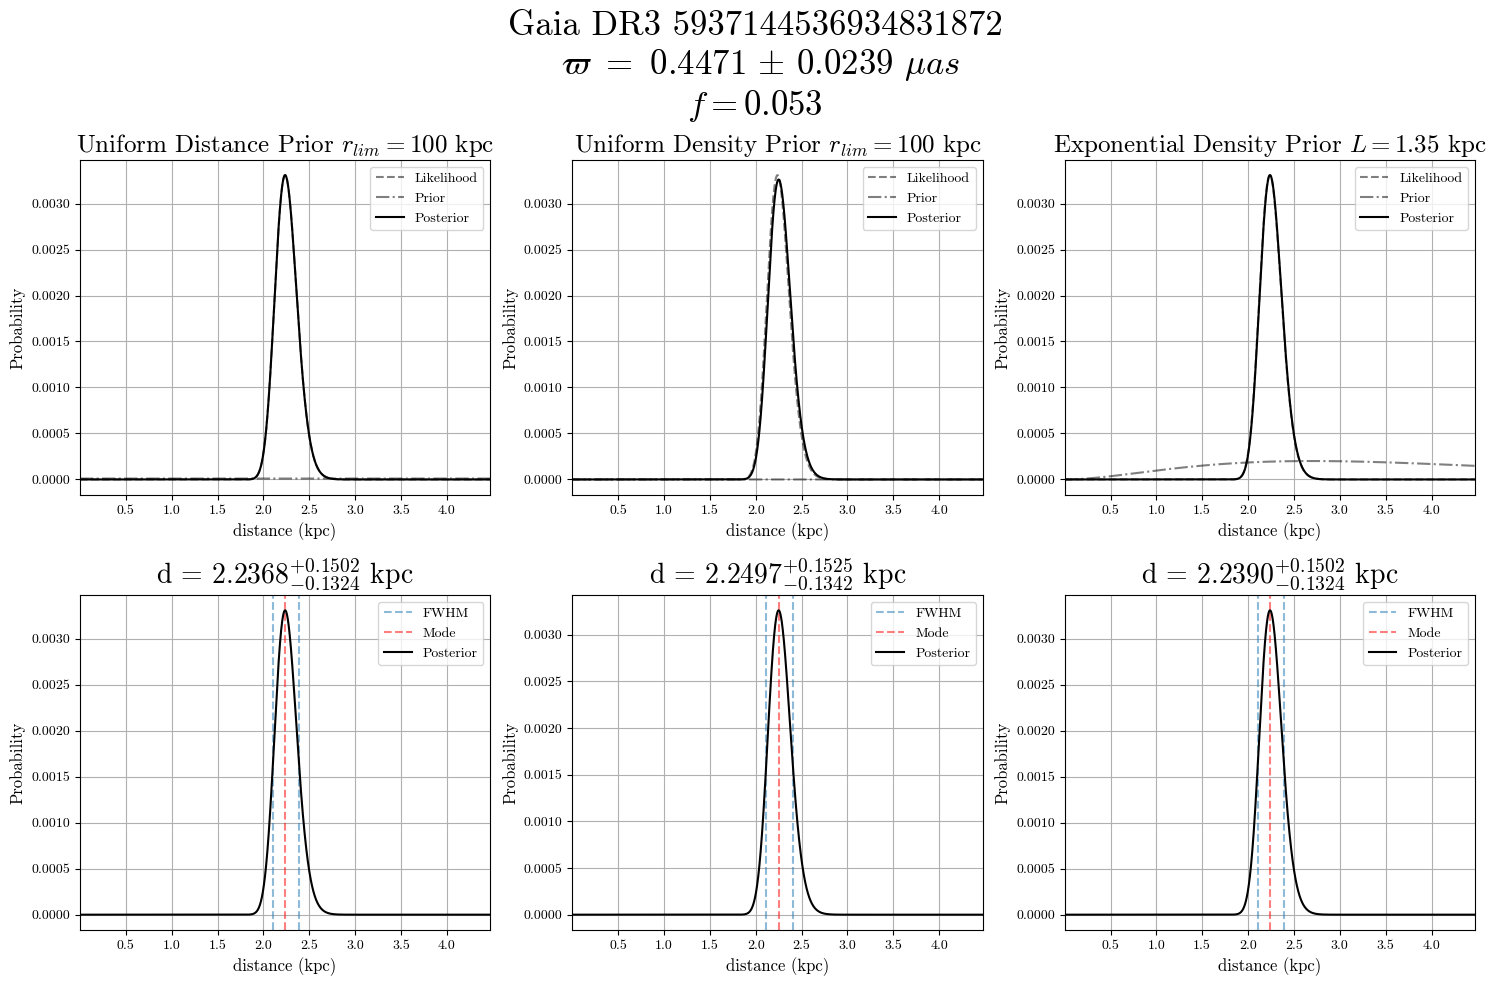

In [47]:
parden(2,"no")

### Print all data

In [ ]:
for i in range (len(data)) :
    parden(i,"yes")

### Save table into csv

In [23]:
data.write('Data GaiaDR3.csv', overwrite=True)

In [45]:
datt.to_csv("Output.csv")

# Done